<h1 style='text-align:center;'>Fraud Data Analysis w/ Ensemble</h1>

## Assignment Notice
Build and compare three models that predict fraud transactions, using the **random forest**, gradient boosting with **XGBoost**, and gradient boosting with **LightGBM**, 

Use various evaluation matrics and adjust parameters depending on your choices of matrics. Your analysis report should provide appropriate justification for your matrics choice and a thorough interpretation of the result. 

***

## 1. Preparing & Refining Data

In [44]:
from imblearn.over_sampling     import SMOTENC
from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import ConfusionMatrixDisplay
from sklearn.metrics            import confusion_matrix
from sklearn.model_selection    import train_test_split
from sklearn.tree               import DecisionTreeClassifier
from sklearn.tree               import plot_tree
import matplotlib.pyplot        as plt
import numpy                    as np
import lightgbm                 as lgb
import pandas                   as pd
import xgboost                  as xgb

In [2]:
# making class as we use this so many times
class Fraud:
    def __init__(self):
        self._file = '../data/2_fraud_ex.csv'
        self._df_origin = pd.read_csv(self._file)
        self._df_origin.rename(columns={'oldbalanceOrg':'oldbalanceOrig'}, inplace=True)
        self._types = {'CASH_IN': 0, 'CASH_OUT': 1, 'PAYMENT': 2, 'DEBIT': 3}
        self._df_origin = self._df_origin[['type', 'amount', 'oldbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'isFraud']]
        self._df_origin['type'] = self._df_origin['type'].apply(lambda x: self._types.get(x, 4))
        self.reset_df()
        self.RAND_SEED = 0
        self._clf = None
    
    @property
    def types(self):
        return self._types
    
    def reset_df(self):
        self._df = self._df_origin.copy()
        
    @property
    def df(self):
        return self._df
        
    def head(self):
        display(self._df.head())
        
    def make_small(self, ratio=0.1):
        _, self._df_small_origin, _, _ = train_test_split(self._df, self._df['isFraud'],
            test_size=ratio, random_state=self.RAND_SEED, stratify=self._df['isFraud'])
        self.reset_df_small()
        
    def reset_df_small(self):
        self._df_small = self._df_small_origin.copy()
        
    @property
    def df_small(self):
        return self._df_small
    
    def prepare_set(self):
        self._df_X = self._df_small.drop(columns='isFraud')
        self._df_y = self._df_small.isFraud

        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(
            self._df_X, self._df_y, random_state=self.RAND_SEED, stratify=self._df_y)
        self._sm = SMOTENC(categorical_features=[0], random_state=self.RAND_SEED, k_neighbors=7)
        self._X_sm_train, self._y_sm_train = self._sm.fit_resample(self._X_train, self._y_train)
        
    def show_shapes(self):
        print(f'X_train {self._X_train.shape} became {self._X_sm_train.shape}')
        print(f'y_train {self._y_train.shape} became {self._y_sm_train.shape}')
        
    def train_data(self):
        return self._X_sm_train, self._y_sm_train
    
    def test_data(self):
        return self._X_test, self._y_test
    
    @property
    def clf(self):
        return self._clf

    @clf.setter
    def clf(self, clf):
        self._clf = clf
    
    def show_score(self, clf=None):
        if clf == None:
            print(f"Train score: {self._clf.score(self._X_sm_train, self._y_sm_train):.3f}")
            print(f"Test score: {self._clf.score(self._X_test, self._y_test):.3f}")
        else:
            print(f"Train score: {clf.score(self._X_sm_train, self._y_sm_train):.3f}")
            print(f"Test score: {clf.score(self._X_test, self._y_test):.3f}")
    
    def show_matrix(self, clf=None):
        if clf == None:
            ConfusionMatrixDisplay.from_estimator(self._clf, self._X_test, self._y_test, display_labels=['Non-Fraud', 'Fraud'])
        else:
            ConfusionMatrixDisplay.from_estimator(clf, self._X_test, self._y_test, display_labels=['Non-Fraud', 'Fraud'])
        plt.show()

    def describe_matrix(self, clf=None):
        if clf == None:
            tn, fp, fn, tp = confusion_matrix(
                self._y_test, self._clf.predict(self._X_test), labels=self._clf.classes_).ravel()
        else:
            tn, fp, fn, tp = confusion_matrix(
                self._y_test, clf.predict(self._X_test), labels=clf.classes_).ravel()

        precision, recall = tp / (tp+fp), tp / (tp+fn)
        pd.options.display.float_format = '{:.3%}'.format
        display(pd.DataFrame({
            'name': ['Accuracy', 'Precision', 'Recall(TPR)', 'F-Score', 'FPR(Type I Error)', 'Type II Error'],
            'value': [(tp+tn) / (tp+tn+fp+fn), precision, recall, 2 * (precision*recall) / (precision+recall),
                fp / (fp+tn), fn / (tp+fn)]
        }))

In [3]:
fraud = Fraud()
fraud.head()

fraud.make_small()
fraud.prepare_set()
fraud.show_shapes()

,type,amount,oldbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,2,9839.64,170136.0,0.0,0.0,0
1,2,1864.28,21249.0,0.0,0.0,0
2,4,181.00,181.0,0.0,0.0,1
3,1,181.00,181.0,21182.0,0.0,1
4,2,11668.14,41554.0,0.0,0.0,0


X_train (477196, 5) became (953160, 5)
y_train (477196,) became (953160,)


## 2. Random Forest

Train score: 1.000
Test score: 0.997


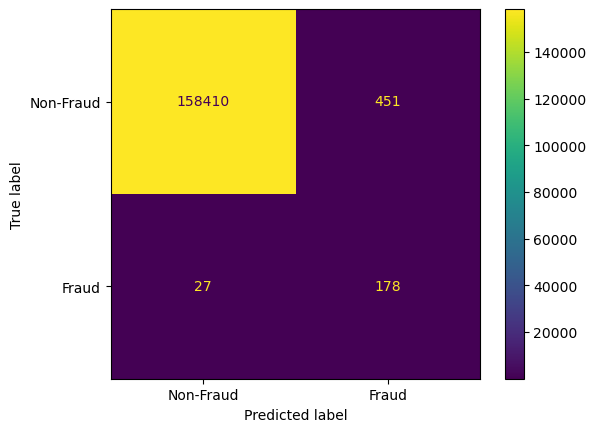

,name,value
0,Accuracy,99.699%
1,Precision,28.299%
2,Recall(TPR),86.829%
3,F-Score,42.686%
4,FPR(Type I Error),0.284%
5,Type II Error,13.171%


In [21]:
forest = RandomForestClassifier(n_jobs=-1, random_state=0).fit(*fraud.train_data())
fraud.clf = forest
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

지난번과 비슷한 양상을 보임. Accuracy는 비교적 높은 편이나 2종오류가 상당히 큼.\
지난번에 최적의 값을 도출한 파라미터 ```min_samples_leaf=500, max_depth=7```를 주고 다시 해봄.

>\
> 현재 이 데이터셋은 **사기거래를 감지하는 것이 목적** 이므로,\
> Non-Fraud를 Fraud로 잘못 예측(1종 오류)한 사례보다\
> **Fraud 데이터를 Non-Fraud로 잘못 예측(2종 오류)** 한\
> 사례를 줄이는 것이 더 중요하다고 판단함.\
>\
> (지난 과제에서 작성한 내용)
>

Train score: 0.972
Test score: 0.945


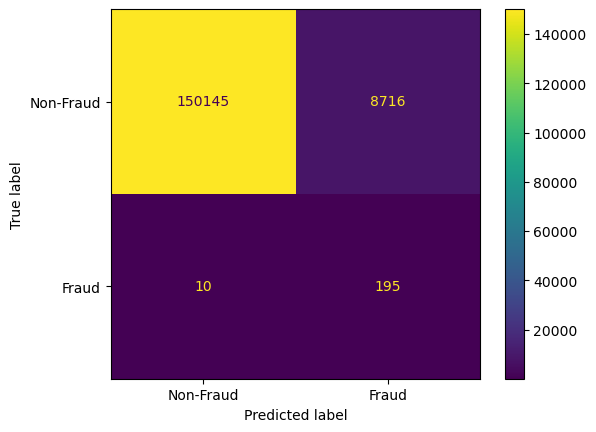

,name,value
0,Accuracy,94.514%
1,Precision,2.188%
2,Recall(TPR),95.122%
3,F-Score,4.278%
4,FPR(Type I Error),5.487%
5,Type II Error,4.878%


In [22]:
forest = RandomForestClassifier(n_jobs=-1, min_samples_leaf=500, max_depth=7, random_state=0).fit(*fraud.train_data())
fraud.clf = forest
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

2종 오류가 크게 감소했으나. 지난번엔 FN값이 4가 나온 것과 대조적으로 10이 나왔다.\
매개변수를 추가로 조절한다.

Train score: 1.000
Test score: 0.998


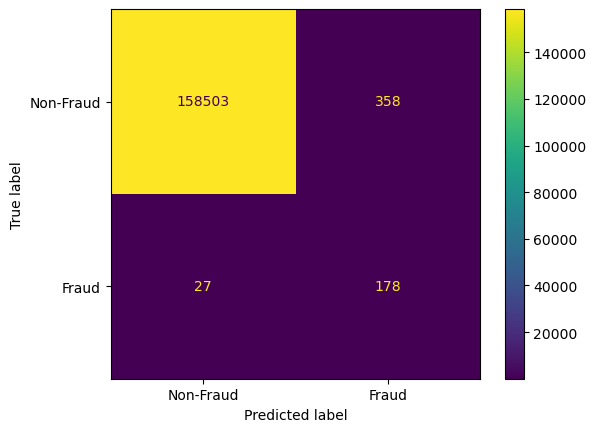

,name,value
0,Accuracy,99.758%
1,Precision,33.209%
2,Recall(TPR),86.829%
3,F-Score,48.043%
4,FPR(Type I Error),0.225%
5,Type II Error,13.171%


In [64]:
forest = RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features=fraud._X_sm_train.shape[1], random_state=0).fit(*fraud.train_data())
fraud.clf = forest
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

```n_estimators``` 값을 늘리자 지나치게 시간이 오래 걸려 더 이상 테스트를 진행할 수 없었다.

## 3. XGBoost

Train score: 0.998
Test score: 0.996


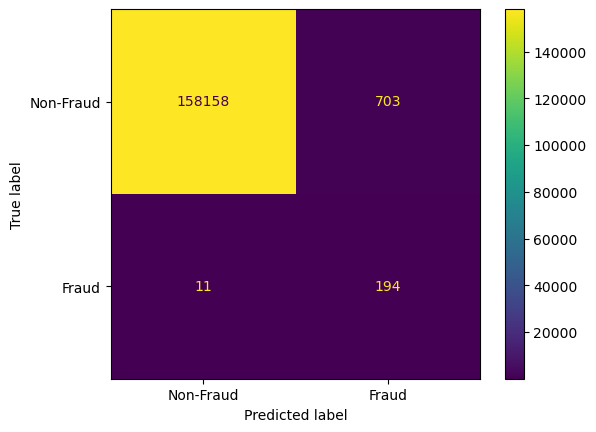

,name,value
0,Accuracy,99.551%
1,Precision,21.628%
2,Recall(TPR),94.634%
3,F-Score,35.209%
4,FPR(Type I Error),0.443%
5,Type II Error,5.366%


In [6]:
xgb_model = xgb.XGBClassifier(random_state=0).fit(*fraud.train_data())
fraud.clf = xgb_model
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

상당히 좋은 점수를 보여준다.

Train score: 0.986
Test score: 0.973


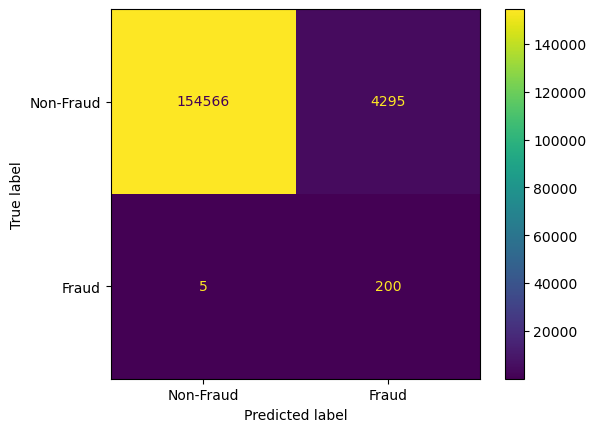

,name,value
0,Accuracy,97.297%
1,Precision,4.449%
2,Recall(TPR),97.561%
3,F-Score,8.511%
4,FPR(Type I Error),2.704%
5,Type II Error,2.439%


In [20]:
xgb_model = xgb.XGBClassifier(random_state=0, max_depth=2).fit(*fraud.train_data())
fraud.clf = xgb_model
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

Train score: 0.990
Test score: 0.981


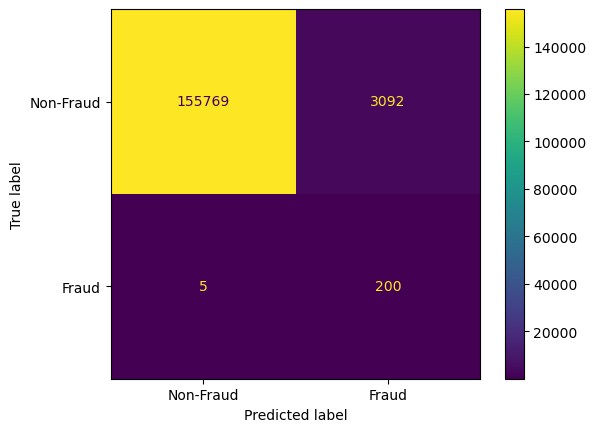

,name,value
0,Accuracy,98.053%
1,Precision,6.075%
2,Recall(TPR),97.561%
3,F-Score,11.438%
4,FPR(Type I Error),1.946%
5,Type II Error,2.439%


In [26]:
xgb_model = xgb.XGBClassifier(random_state=0, learning_rate=0.07).fit(*fraud.train_data())
fraud.clf = xgb_model
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

Train score: 0.988
Test score: 0.975


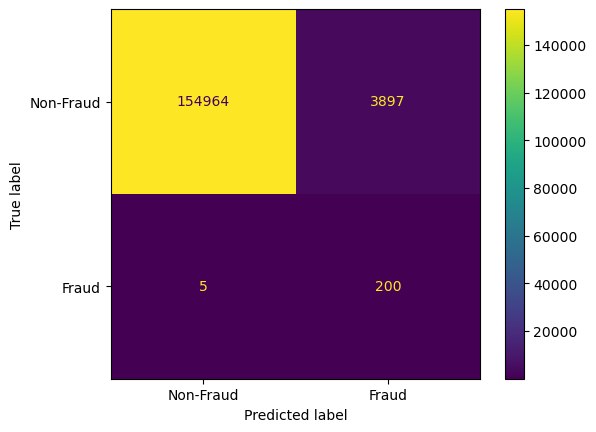

,name,value
0,Accuracy,97.547%
1,Precision,4.882%
2,Recall(TPR),97.561%
3,F-Score,9.298%
4,FPR(Type I Error),2.453%
5,Type II Error,2.439%


In [36]:
xgb_model = xgb.XGBClassifier(random_state=0, max_depth=4, learning_rate=0.1).fit(*fraud.train_data())
fraud.clf = xgb_model
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

```xgb.XGBClassifier(random_state=0, learning_rate=0.07)```\
XGB에선 위 파라미터를 사용하는 것이 가장 좋은 성능을 보였다.\
T1E 1.9%, T2E 2.4%

## 4. LightGBM

Train score: 0.996
Test score: 0.991


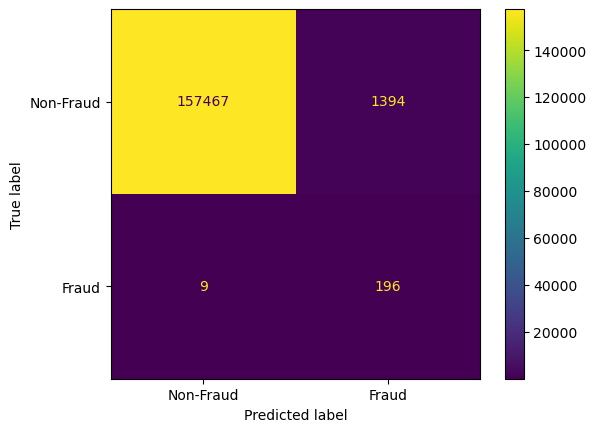

,name,value
0,Accuracy,99.118%
1,Precision,12.327%
2,Recall(TPR),95.610%
3,F-Score,21.838%
4,FPR(Type I Error),0.877%
5,Type II Error,4.390%


In [46]:
gbm = lgb.LGBMClassifier(random_state=0).fit(*fraud.train_data())
fraud.clf = gbm
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

Train score: 0.994
Test score: 0.988


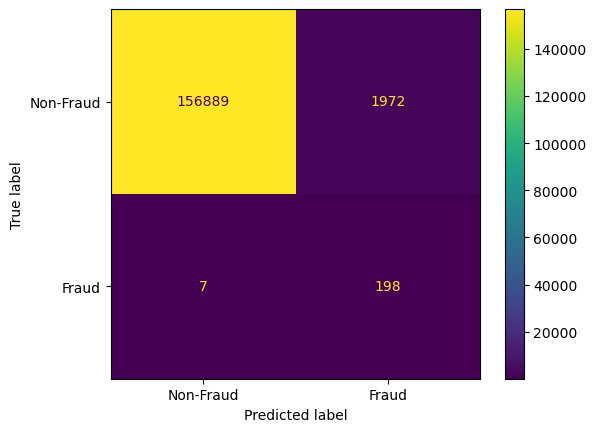

,name,value
0,Accuracy,98.756%
1,Precision,9.124%
2,Recall(TPR),96.585%
3,F-Score,16.674%
4,FPR(Type I Error),1.241%
5,Type II Error,3.415%


In [54]:
gbm = lgb.LGBMClassifier(num_leaves=20, random_state=0).fit(*fraud.train_data())
fraud.clf = gbm
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

Train score: 0.994
Test score: 0.988


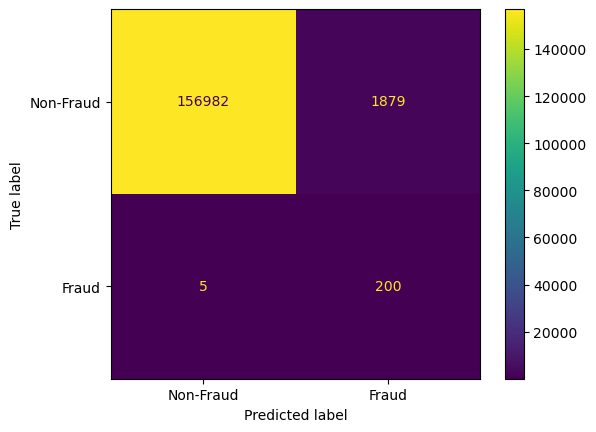

,name,value
0,Accuracy,98.816%
1,Precision,9.620%
2,Recall(TPR),97.561%
3,F-Score,17.513%
4,FPR(Type I Error),1.183%
5,Type II Error,2.439%


In [63]:
gbm = lgb.LGBMClassifier(num_leaves=5, learning_rate=0.5, random_state=0).fit(*fraud.train_data())
fraud.clf = gbm
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

## Conclusion

LightGBM에서, ```num_leaves=5, learning_rate=0.5``` 옵션을 적용한 모델이 가장 성능이 준수했음. 랜덤 포레스트, XGB, LGB를 종합적으로 사용해본 결과 랜덤 포레스트의 성능이 상대적으로 떨어짐을 확인하였고, XGB와 LGB는 파라미터 값을 조정하여 1, 2종 오류를 모두 크게 낮출 수 있었음. XGB와 LGB 모두 2종오류를 2.4%까지 낮추었으나, LGB의 경우 FPR도 1.2%로 크게 낮출 수 있었음.